# CW1 Part II: Apples Binary Classification with MoG

In [1]:
import os
import sys
import glob
import time
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## A) Importing the training Images

In [2]:
imgfiles = sorted(glob.glob("apples/train_*.jpg"))
maskfiles = sorted(glob.glob("apple_masks/train_*.png"))

imgs_raw = []
masks_raw = []
for maskfile, imgfile in zip(maskfiles, imgfiles):
    imgs_raw.append(plt.imread(imgfile))
    masks_raw.append(plt.imread(maskfile)[:, :, 0])

imgs = [img / 255. for img in imgs_raw] # Normalize the images
masks = [np.array(mask > 0.5, dtype="float") for mask in masks_raw] # Threshold the masks

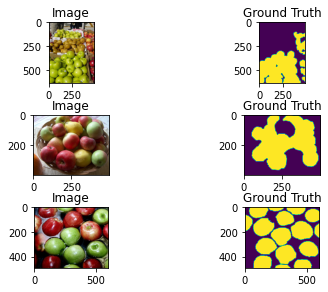

In [3]:
nTests = len(imgs)
fig, axs = plt.subplots(nTests, 2)
fig.tight_layout()
for i in range(nTests):
    axs[i, 0].imshow(imgs[i])
    axs[i, 0].set_title("Image")
    axs[i, 1].imshow(masks[i])
    axs[i, 1].set_title("Ground Truth")

In [4]:
def gen_training_data(masks, imgs):
    """Generate two 3xn matrices containing all apple pixels and all nonapple pixels"""
    is_apple = [[], [], []]
    non_apple = [[], [], []]
    for mask, img in zip(masks, imgs):
        imgfs = img.reshape(-1, 3)
        maskfs = mask.flatten()
        for maskf, imgf in zip(maskfs, imgfs):
            if maskf == 1:
                is_apple[0].append(imgf[0])
                is_apple[1].append(imgf[1])
                is_apple[2].append(imgf[2])
            else:
                non_apple[0].append(imgf[0])
                non_apple[1].append(imgf[1])
                non_apple[2].append(imgf[2])
    is_apple = np.float32(is_apple)
    non_apple = np.float32(non_apple)
    
    # Check that our total number of pixels match
    assert sum([i.shape[0] * i.shape[1] for i in imgs]) == \
        is_apple.shape[1] + non_apple.shape[1]
    return is_apple, non_apple

is_apple_data, non_apple_data = gen_training_data(masks, imgs)

# B) Implementing MoG Model

Most of this code is taken from my vectorized version of practical C

In [5]:
def calc_elementwise_like(data, mix_gauss_est):
    """
    Calculates the likelihood that each data point comes from each Gaussian.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mix_gauss_est -- dict containing the estimated MoG parameters.
    
    Returns: 
    like -- n by k matrix.
    """
    
    D, nData = data.shape
    assert D == mix_gauss_est["d"], (D, mix_gauss_est["d"])
    
    K = mix_gauss_est["k"]
    
    Sigma = mix_gauss_est["cov"].transpose(2, 0, 1)
    X = data.T[:, None]
    Mu = mix_gauss_est["mean"].T
    
    exp = np.exp(-0.5 * np.einsum("nab, kbc, ndc->nkad", X-Mu, np.linalg.inv(Sigma), X-Mu))
    exp_diag = mix_gauss_est["weight"] * np.diagonal(np.einsum("niij -> nij", exp), axis1=1, axis2=2)
    like = 1 / ((2 * np.pi) ** (D / 2) * (np.linalg.det(Sigma)) ** 0.5) * exp_diag
    return like

In [6]:
def get_mix_gauss_log_like(data, mix_gauss_est): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mix_gauss_est -- dict containing the mixture of gaussians parameters.

    Returns: 
    log_like -- n vector containing the log likelihood for each pixel.
    
    """
    
    like = np.sum(calc_elementwise_like(data, mix_gauss_est), axis=1)
    log_like = np.sum(np.log(like))

    return log_like

In [7]:
def fit_mix_gauss(data, k, nIter=10):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mix_gauss_est -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE   
    nDims, nData = data.shape

    # we will initialize the MoG to random values
    mix_gauss_est = dict()
    mix_gauss_est['d'] = nDims
    mix_gauss_est['k'] = k
    mix_gauss_est['weight'] = (1 / k) * np.ones(shape=(k))
    mix_gauss_est['mean'] = 2 * np.random.randn(nDims, k)
    mix_gauss_est['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mix_gauss_est['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    log_like = get_mix_gauss_log_like(data, mix_gauss_est)
    print('Iter 0: Log Likelihood is {:.3f}. 0s elapsed'.format(log_like))

    log_likes = np.zeros(shape=(nIter + 1))
    log_likes[0] = log_like

    tic = time.perf_counter()
    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        posteriors = calc_elementwise_like(data, mix_gauss_est)
        post_e_step = posteriors.T / np.sum(posteriors, axis=1)

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            thisQ = post_e_step[cGauss]
            # Update weighting parameters based on the total
            # posterior probability associated with each Gaussian.
            mix_gauss_est['weight'][cGauss] = np.sum(thisQ) / np.sum(post_e_step)
            
            # Update mean parameters by weighted average where weights
            # are given by posterior probability associated with Gaussian.
            mix_gauss_est['mean'][:,cGauss] = thisQ @ data.T / np.sum(thisQ)
            
            # Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with each Gaussian
            mu_k = mix_gauss_est["mean"][:, cGauss]
            
            mix_gauss_est['cov'][:,:,cGauss] = np.einsum("n,ni,nj->ij", thisQ, (data.T - mu_k), (data.T - mu_k)) / np.sum(thisQ)
        
        # calculate the log likelihood and other metrics
        toc = time.perf_counter() - tic
        log_like = get_mix_gauss_log_like(data, mix_gauss_est)
        log_likes[cIter+1] = log_like
        print('Iter {}: Log Likelihood is {:.3f}. {:.2f}s elapsed'.format(cIter+1, log_like, toc))
    return {"model": mix_gauss_est, "log_like": log_likes}

def run_training(k_gaussians, use_is_apple_data=True, nIter=10):
    """Helper function to easily run training on apple and nonapple data"""
    if use_is_apple_data:
        model_output = fit_mix_gauss(is_apple_data, k_gaussians, nIter=nIter)
    else:
        model_output = fit_mix_gauss(non_apple_data, k_gaussians, nIter=nIter)
    return model_output

In [8]:
model_k2_is_apple = run_training(2, use_is_apple_data=True, nIter=30)

Iter 0: Log Likelihood is -6243016.868. 0s elapsed
Iter 1: Log Likelihood is 283099.780. 0.70s elapsed
Iter 2: Log Likelihood is 283099.848. 2.10s elapsed
Iter 3: Log Likelihood is 283102.322. 3.51s elapsed
Iter 4: Log Likelihood is 283491.776. 4.91s elapsed
Iter 5: Log Likelihood is 295309.287. 6.31s elapsed
Iter 6: Log Likelihood is 308385.586. 7.72s elapsed
Iter 7: Log Likelihood is 317252.035. 9.13s elapsed
Iter 8: Log Likelihood is 327012.363. 10.53s elapsed
Iter 9: Log Likelihood is 338603.668. 11.94s elapsed
Iter 10: Log Likelihood is 353164.722. 13.34s elapsed
Iter 11: Log Likelihood is 370155.616. 14.74s elapsed
Iter 12: Log Likelihood is 386141.237. 16.14s elapsed
Iter 13: Log Likelihood is 397948.304. 17.54s elapsed
Iter 14: Log Likelihood is 405506.408. 18.94s elapsed
Iter 15: Log Likelihood is 410055.910. 20.34s elapsed
Iter 16: Log Likelihood is 412744.784. 21.75s elapsed
Iter 17: Log Likelihood is 414400.239. 23.15s elapsed
Iter 18: Log Likelihood is 415508.236. 24.55s e

In [9]:
model_k3_is_apple = run_training(3, use_is_apple_data=True, nIter=30)

Iter 0: Log Likelihood is -6570641.896. 0s elapsed
Iter 1: Log Likelihood is 283099.773. 1.58s elapsed
Iter 2: Log Likelihood is 283099.774. 4.74s elapsed
Iter 3: Log Likelihood is 283099.788. 7.90s elapsed
Iter 4: Log Likelihood is 283099.991. 11.06s elapsed
Iter 5: Log Likelihood is 283103.503. 14.22s elapsed
Iter 6: Log Likelihood is 283174.339. 17.37s elapsed
Iter 7: Log Likelihood is 284675.923. 20.54s elapsed
Iter 8: Log Likelihood is 299415.332. 23.72s elapsed
Iter 9: Log Likelihood is 326073.179. 26.92s elapsed
Iter 10: Log Likelihood is 351094.910. 30.10s elapsed
Iter 11: Log Likelihood is 378830.712. 33.27s elapsed
Iter 12: Log Likelihood is 408548.204. 36.43s elapsed
Iter 13: Log Likelihood is 428694.175. 39.61s elapsed
Iter 14: Log Likelihood is 443984.754. 42.80s elapsed
Iter 15: Log Likelihood is 457995.758. 45.96s elapsed
Iter 16: Log Likelihood is 471622.019. 49.10s elapsed
Iter 17: Log Likelihood is 484754.873. 52.24s elapsed
Iter 18: Log Likelihood is 497509.313. 55.3

In [10]:
model_k2_non_apple = run_training(2, use_is_apple_data=False, nIter=30)

Iter 0: Log Likelihood is -3030114.136. 0s elapsed
Iter 1: Log Likelihood is 411652.364. 0.61s elapsed
Iter 2: Log Likelihood is 414226.485. 1.83s elapsed
Iter 3: Log Likelihood is 428602.712. 3.06s elapsed
Iter 4: Log Likelihood is 467463.954. 4.29s elapsed
Iter 5: Log Likelihood is 502848.078. 5.52s elapsed
Iter 6: Log Likelihood is 527448.721. 6.75s elapsed
Iter 7: Log Likelihood is 551187.453. 7.97s elapsed
Iter 8: Log Likelihood is 569021.087. 9.20s elapsed
Iter 9: Log Likelihood is 578051.189. 10.43s elapsed
Iter 10: Log Likelihood is 583217.651. 11.65s elapsed
Iter 11: Log Likelihood is 586854.796. 12.87s elapsed
Iter 12: Log Likelihood is 589573.721. 14.10s elapsed
Iter 13: Log Likelihood is 591638.054. 15.33s elapsed
Iter 14: Log Likelihood is 593278.800. 16.55s elapsed
Iter 15: Log Likelihood is 594646.924. 17.78s elapsed
Iter 16: Log Likelihood is 595868.213. 19.02s elapsed
Iter 17: Log Likelihood is 597137.474. 20.25s elapsed
Iter 18: Log Likelihood is 598784.681. 21.48s el

In [11]:
model_k3_non_apple = run_training(3, use_is_apple_data=False, nIter=30)

Iter 0: Log Likelihood is -1828477.049. 0s elapsed
Iter 1: Log Likelihood is 426791.204. 1.38s elapsed
Iter 2: Log Likelihood is 492154.912. 4.15s elapsed
Iter 3: Log Likelihood is 580680.795. 6.92s elapsed
Iter 4: Log Likelihood is 627282.278. 9.69s elapsed
Iter 5: Log Likelihood is 639261.368. 12.46s elapsed
Iter 6: Log Likelihood is 643760.989. 15.22s elapsed
Iter 7: Log Likelihood is 646655.742. 17.99s elapsed
Iter 8: Log Likelihood is 649541.055. 20.76s elapsed
Iter 9: Log Likelihood is 653984.688. 23.52s elapsed
Iter 10: Log Likelihood is 664767.520. 26.29s elapsed
Iter 11: Log Likelihood is 692143.016. 29.06s elapsed
Iter 12: Log Likelihood is 722038.424. 31.82s elapsed
Iter 13: Log Likelihood is 731318.085. 34.60s elapsed
Iter 14: Log Likelihood is 733533.011. 37.38s elapsed
Iter 15: Log Likelihood is 734547.600. 40.17s elapsed
Iter 16: Log Likelihood is 735165.487. 42.96s elapsed
Iter 17: Log Likelihood is 735591.235. 45.74s elapsed
Iter 18: Log Likelihood is 735910.604. 48.54

## Comments on E-M Algorithm

Some strange behavior was observed with the E-M algorithm, specifically in the log likelihood calculation. To reduce the strain of very small values, I normalized all the images (by dividing through by `255.`). This appears to have caused the negative log likelihood to flip to positive after the first epoch. I am not quite sure how to explain this other than pointing out what I deduce to be the cause of the behavior (I don't believe this is overflow due to the relatively normal behavior of the likelihood with regard to its convergence).

## Best Model Parameters

After running a gridsearch on all permutations of 1, 2, 3, 4 & 5 Gaussians for both the apple and non-apple data, using the mean area under ROC curve for my five test images as a metric, I have determined that the optimal parameters are 3 Gaussians for tha apple data and 2 Gaussians for the non-apple data. This is in line with intuition, given that apples tend appear as green, yellowish orange and red in the training data and the backgrounds tend to be either dark or white.

I also noticed that the number of epochs does matter. When running with 20 and 30 epochs, I observed that convergence only takes place around iteration 15-20, or even later with 4 or 5 Gaussians.

# C) Using Model on Test Images

## Importing Test Images

In [12]:
def import_test_images():
    test_mask_files = sorted(glob.glob("apple_masks/test_*.png"))
    test_img_files = sorted(glob.glob("apples/test_*.jpg"))

    test_imgs_raw = []
    test_masks_raw = []
    for maskfile, imgfile in zip(test_mask_files, test_img_files):
        test_imgs_raw.append(plt.imread(imgfile))
        test_masks_raw.append(plt.imread(maskfile)[:, :, 0])

    test_imgs = [i / 255. for i in test_imgs_raw]
    test_masks = [np.array(mask > 0.5, dtype="float") for mask in test_masks_raw]
    return test_imgs, test_masks

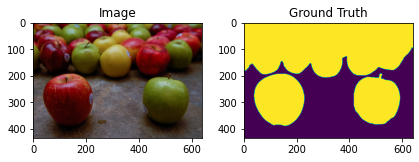

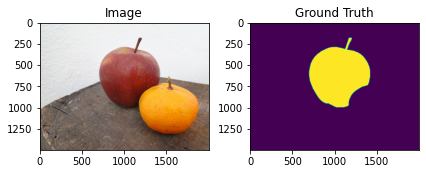

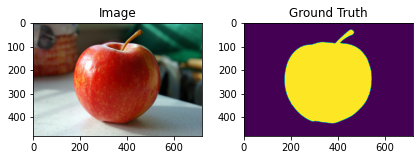

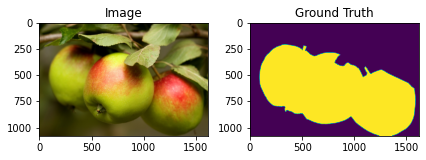

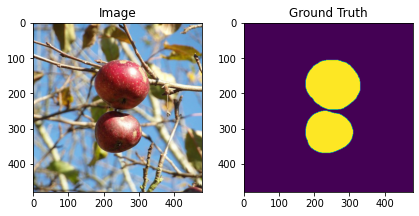

In [13]:
test_imgs, test_masks = import_test_images()
nTests = len(test_imgs)

for i in range(nTests):
    fig, axs = plt.subplots(1, 2)
    fig.tight_layout()
    axs[0].imshow(test_imgs[i])
    axs[0].set_title("Image")
    axs[1].imshow(test_masks[i])
    axs[1].set_title("Ground Truth")
    plt.show()

In [14]:
def get_posterior(im, mixGaussApple, mixGaussNonApple, pApple, pNonApple):
    """Use Bayes' Rule to get the posterior probability of each pixel being an apple or not"""
    imY, imX, imZ = im.shape
    like_apple = calc_elementwise_like(im.reshape(-1, imZ).T, mixGaussApple).sum(axis=1).reshape(imY, imX)
    like_non_apple = calc_elementwise_like(im.reshape(-1, imZ).T, mixGaussNonApple).sum(axis=1).reshape(imY, imX)
    posterior = like_apple * pApple / (like_apple * pApple + like_non_apple * pNonApple)
    assert posterior.shape == (imY, imX)
    return posterior

In [15]:
outputs={}

In [18]:
def get_output(is_apple_model, non_apple_model, applePrior):
    """Calculate the posterior for each test image and display next to ground truth"""
    print("Trying apple prior", applePrior)
    applePrior, nonApplePrior = applePrior, 1-applePrior
    output = {"posteriors": [], "label": "ApplePrior: {}, nonApplePrior: {}".format(applePrior, nonApplePrior)}
    for i in range(len(test_imgs)):
        fig, axs = plt.subplots(1, 3)
        fig.tight_layout()
        axs[0].imshow(test_imgs[i])
        axs[0].set_title("Image")
        this_out = get_posterior(test_imgs[i], is_apple_model, non_apple_model, applePrior, nonApplePrior)
        axs[1].imshow(this_out)
        axs[2].imshow(test_masks[i])
        axs[2].set_title("Ground Truth")
        plt.show()
        output["posteriors"].append(this_out)
    return output

Trying apple prior 0.4


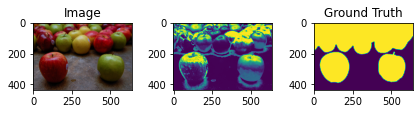

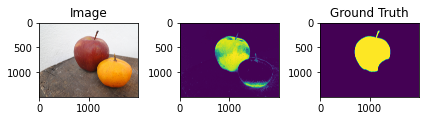

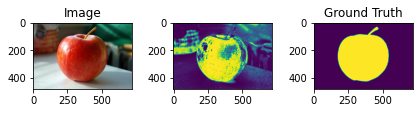

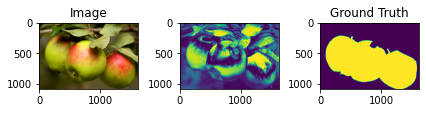

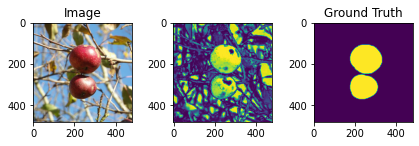

In [19]:
# 3 apple Gaussians, 3 non-apple Gaussians
outputs["k3nk3_0.4"] = get_output(
    model_k3_is_apple["model"], 
    model_k3_non_apple["model"],
    0.4,
)

Trying apple prior 0.4


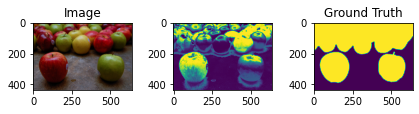

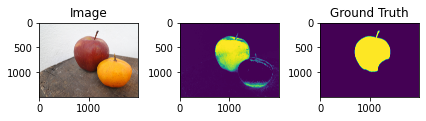

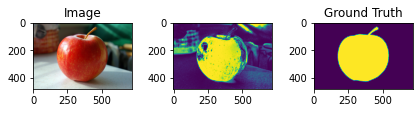

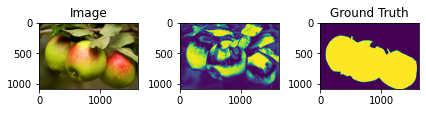

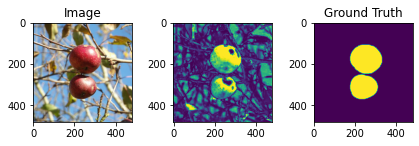

In [20]:
# 3 apple Gaussians, 2 non-apple Gaussians
outputs["k3nk2_0.4"] = get_output(
    model_k3_is_apple["model"], 
    model_k2_non_apple["model"],
    0.4,
)

## Comments on Outputs

The outputs here are mixed. Clearly, they are very challenging images from the perspective of classifying based on individual pixel values, since the pixel values of some non-apple pixels are the same as apple pixels and vice-versa.

Nonetheless, on the tangerine photo (which is rather challenging due to the red hue of the bottom of the tangerine), the output is very close to the ground truth, and my test apple (index 2) also works very well. With the green apples on the branch, the similarity of colors is extremely difficult to separate for the model and so they all struggled here. There are also mixed results on the first photo, with the yellow apple being misclassified (as is expected, due to the similar coloring to the pears in one of the training images. Finally, my red apples image (index 4) has worked decently, with some false positives on the leaves of the tree, due to the way they catch the orange light.

# D) Quantifying the Results (ROC Curve and AUC)

Below are methods for calculating the true positive rates (TPRs), false positive rates (FPRs) and area under curves (AUCs) for each image in the test suite.

NB: The results displayed here are after a new run (previous results achieved better than 84% AUC but the algorithm is stochastic)

In [21]:
def get_TPR_FPR(posterior, ground_truth, threshold):
    res = {"TP": 0, "TN": 0, "FP": 0, "FN": 0}
    pred = posterior > threshold
    
    # Cite for vectorized code: https://kawahara.ca/how-to-compute-truefalse-positives-and-truefalse-negatives-in-python-for-binary-classification-problems/
    res["TP"] = np.sum(np.logical_and(pred == 1, ground_truth == 1))
    res["TN"] = np.sum(np.logical_and(pred == 0, ground_truth == 0))
    res["FN"] = np.sum(np.logical_and(pred == 0, ground_truth == 1))
    res["FP"] = np.sum(np.logical_and(pred == 1, ground_truth == 0))
    res["TPR"] = res["TP"] / (res["TP"] + res["FN"])
    res["FPR"] = res["FP"] / (res["FP"] + res["TN"])
    return res["TP"] / (res["TP"] + res["FN"]), res["FP"] / (res["FP"] + res["TN"])

In [22]:
def get_curves_for_masks(posteriors, masks):
    thresholds = np.arange(0, 1, step=0.005)
    TPRs = np.zeros((thresholds.shape[0], nTests))
    FPRs = np.zeros((thresholds.shape[0], nTests))
    nThresholds = TPRs.shape[0]
    nMasks = len(masks)    
    for i in range(nThresholds):
        for j in range(nMasks):
            TPRs[i, j], FPRs[i, j] = get_TPR_FPR(posteriors[j], masks[j], thresholds[i])
    return TPRs, FPRs

In [23]:
def plot_ROC_curve(TPRs, FPRs):
    plt.plot(FPRs, TPRs)
    plt.plot(np.arange(1.1, step=0.1), np.arange(1.1, step=0.1), ":")
    plt.show()

In [24]:
def calc_AUC(TPRs, FPRs):
    results = []
    for i in range(TPRs.shape[1]):
        results.append(np.trapz(TPRs[::-1, i], x=FPRs[::-1, i]))
    return results

In [25]:
def get_metrics(outputs_key):
    print("Metrics for {}".format(outputs_key))
    TPRs, FPRs = get_curves_for_masks(outputs[outputs_key]["posteriors"], test_masks)
    AUCs = calc_AUC(TPRs, FPRs)
    plot_ROC_curve(TPRs, FPRs)
    for index, result in enumerate(AUCs):
        print("Test image {} had AUC of {:.2%}".format(index, result))
    print("Mean of all images: {:.2%}".format(np.mean(AUCs)))

Metrics for k3nk3_0.4


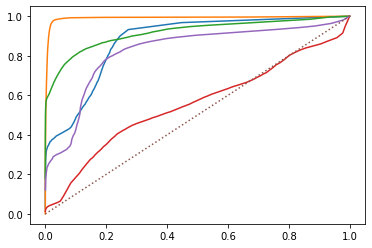

Test image 0 had AUC of 87.49%
Test image 1 had AUC of 99.16%
Test image 2 had AUC of 91.77%
Test image 3 had AUC of 55.45%
Test image 4 had AUC of 82.38%
Mean of all images: 83.25%


In [27]:
# 3 apple Gaussians, 3 non-apple Gaussians
get_metrics("k3nk3_0.4")

Metrics for k3nk2_0.4


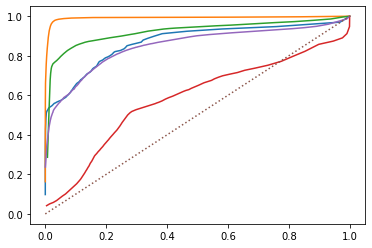

Test image 0 had AUC of 86.96%
Test image 1 had AUC of 99.21%
Test image 2 had AUC of 92.01%
Test image 3 had AUC of 58.35%
Test image 4 had AUC of 85.00%
Mean of all images: 84.31%


In [26]:
# 3 apple Gaussians, 2 non-apple Gaussians
get_metrics("k3nk2_0.4")

## Comments on ROC results

As was expected based on the visual appearance of the posterior outputs, the ROC curve results are mixed. In this view, however, we only really see an issue with the red curve (corresponding to the green apples on a branch) where it even dips below the *random chance* line. The other curves are relatively good, with Test image 1 (red apple with tangerine) giving 99.21% AUC with the apple 3 Gaussians, non-apple 2 Gaussians model.

## Best Priors

After careful consideration of the prevalance of apples in the test images, as well as some testing of different values (at a scale of `10^-1` from 0 to 1 then `10^-2`) with a few different models, it seems that an apple prior of 0.4 with non-apple prior of 0.6 gives the best results, based on both the area under ROC curve and visually.

# E) Custom Test Images

Below are the given test images (two of which have custom masks) and two custom test images with custom masks (indices 2 and 4)

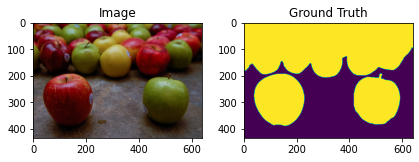

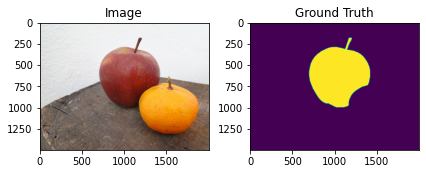

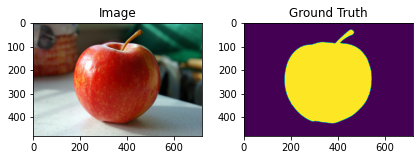

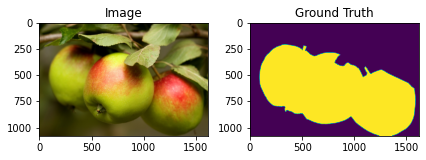

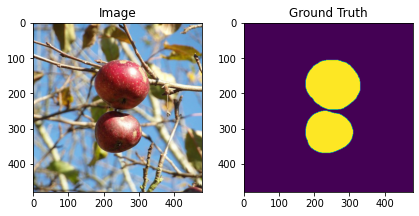

In [28]:
test_imgs, test_masks = import_test_images()
nTests = len(test_imgs)

for i in range(nTests):
    fig, axs = plt.subplots(1, 2)
    fig.tight_layout()
    axs[0].imshow(test_imgs[i])
    axs[0].set_title("Image")
    axs[1].imshow(test_masks[i])
    axs[1].set_title("Ground Truth")
    plt.show()

# F) Why should we split our data into training, validation and testing?

When building machine learning models, we are trying to maximise the ability for the model to generalize on new data. To be able to achieve this, we need a way to evaluate the model after the optimal hyperparameters have been set, and our model has trained. The issue with having only a training set and a test set is that there is no way to adjust hyperparameters without using the test set, meaning that we could set our hyperparameters to work best on the test set, without them actually generalizing well.

For this reason, it is best to have a validation set that we can use to validate sets of hyperparameters after we have trained a model with a training set. Finally, we can test this model on our test set and know that there has been no bias in arriving at the final results.

Another idea would be to use cross-validation. This is a technique where we split the training data into multiple bins, then we take the validation set at random from one of the bins and train on the other bins. We continue to do this until every bin has been used as a validation set. By the end, we get a set of results that (given sufficiently numerous and diverse data) should be very reflective of the model's ability to generalize to new images.
